# Lesson 07: Neutron Captures Continued
### Dylan Temples 
June 20, 2022

The goal of this lesson is to do a back-of-the-envelope calculation for Sb neutron capture for DD neutrons. Increasing levels of complexity are applied.

## Learning Objectives
Physics Topics:
- Neutron capture
- Interaction rate calculation

Programming Topics:
- Interpolation
- Distributions, sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
## Simulation parameters
m_Sb_g   = 1.0
Sb_src_dist_z_cm = 5.0     ## units = cm
r_Abs_cm = 10.0  # cm
R_n_psec = 1e8   # neutrons / sec, isotropically

## Antimony properties
Sb_density_g_cm3 = 6.697 ## At room temperature
MM_Sb_g_mol = 121.76
Sb_f121 = 0.5721
Sb_f123 = 0.4279
tau_122Sb_sec =  2.7238 * 24. * 3600.
tau_124Sb_sec = 60.20   * 24. * 3600.

## Fundamental constants
M_neutron_MeV = 939.565420

## Unit conversions
b_to_cm2  = 1e-24 ## 1 barn = 10^-28 m^2 = 10^-24 cm^2
eV_to_MeV = 1e-6  ## 1 eV = 10^-6 MeV
mol       = 6.02e23

## File names
Sb121_file = "endf-6[29111].txt"
Sb123_file = "endf-6[33736].txt"

In [4]:
def SbVolume(Sb_mass_g):
    
    SbSphereVol_cm3 = Sb_mass_g / Sb_density_g_cm3
    
    return SbSphereVol_cm3

def SbRadius(Sb_mass_g):
    
    SbSphereRad_cm = np.power( (3./(4.*np.pi)) * SbVolume(Sb_mass_g) , 1./3.)
    
    return SbSphereRad_cm

def SbCircle(Sb_mass_g):
    
    SbSphereXAr_cm2 = np.pi * np.power( SbRadius(Sb_mass_g) ,2.)
    
    return SbSphereXAr_cm2

In [5]:
def MoleMathByIsotope(Sb_mass_g):
    N_moles_in_mass = m_Sb_g / MM_Sb_g_mol
    N_atoms_Sb      = mol * N_moles_in_mass
    Sb_num_dens     = N_atoms_Sb / SbVolume(m_Sb_g)
    Sb121_N         = Sb_f121 * N_atoms_Sb
    Sb123_N         = Sb_f123 * N_atoms_Sb
    return Sb_num_dens, Sb121_N, Sb123_N

In [6]:
def TotalNeutronFlux(generation_rate_Hz, absorber_radius_cm):
    
    flux_cm2_sec = generation_rate_Hz / (4.*np.pi*np.power(absorber_radius_cm,2.))
    
    return flux_cm2_sec

In [7]:
def MakeCrossSectionPlot(filename, pMeV=False):
    ## Pull the data from the fle, skipping the header
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    
    ## Now pull the header line to create the plot title
    firstline = None
    with open(filename) as f:
        firstline = f.readline().rstrip()
        
    iso_pts = firstline.split("(")[0].split("-")
    iso_str = r"$^{"+iso_pts[2]+"}_{"+iso_pts[0]+"}$"+iso_pts[1]
    int_pts = firstline.split("(")[1].split(")")[0].split(",")
    int_str = r"($"+int_pts[0]+",\\"+int_pts[1].replace(";","").replace("&","")+"$)"
    
    fig = plt.figure()
    ax0 = fig.gca()
    
    if pMeV:
        ax0.plot(data[:,0]*eV_to_MeV,data[:,1]*b_to_cm2,'b-')
        ax0.set_xlabel("Energy [MeV]")
        ax0.set_ylabel(r"Cross-section [cm$^2$]")
    else:
        ax0.plot(data[:,0],data[:,1],'b-')
        ax0.set_xlabel("Energy [eV]")
        ax0.set_ylabel(r"Cross-section [b]")
                                                                    
    ax0.set_title(iso_str+" "+int_str)

    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.grid(True)  
    
    ## Create and return the interpolator
    return interp1d(data[:,0]*eV_to_MeV,data[:,1]*b_to_cm2)

In [8]:
def NeutronVelocity(E_neutron_MeV):
    
    beta = np.sqrt(2*E_neutron_MeV/M_neutron_MeV)
    
    return beta

In [9]:
def Activity_Bq(N_decayers, t12_sec):
    return N_decayers * np.log(2.) / t12_sec

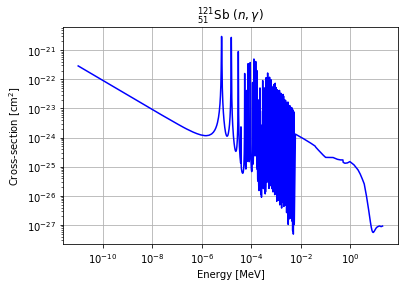

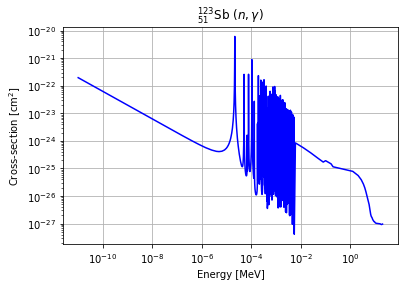

In [10]:
Sb_num_dens, Sb121_N, Sb123_N = MoleMathByIsotope(m_Sb_g)
Sb121_xsec_intp = MakeCrossSectionPlot("endf-6[29111].txt", pMeV=True)
Sb123_xsec_intp = MakeCrossSectionPlot("endf-6[33736].txt", pMeV=True)

In [11]:
Sb121_cap_rate = TotalNeutronFlux(R_n_psec, Sb_src_dist_z_cm) * Sb121_xsec_intp(2.45) * Sb121_N
Sb123_cap_rate = TotalNeutronFlux(R_n_psec, Sb_src_dist_z_cm) * Sb123_xsec_intp(2.45) * Sb123_N
print("For this source and target, there are", Sb121_cap_rate, "122Sb activations per second")
print("For this source and target, there are", Sb123_cap_rate, "124Sb activations per second")

For this source and target, there are 52.88467586500974 122Sb activations per second
For this source and target, there are 30.95472789768153 124Sb activations per second


In [12]:
print("In a one second exposure with no decays, the final activities are")
print("122Sb:", Activity_Bq(Sb121_cap_rate*1.0, tau_122Sb_sec), "Bq")
print("124Sb:", Activity_Bq(Sb123_cap_rate*1.0, tau_124Sb_sec), "Bq")

In a one second exposure with no decays, the final activities are
122Sb: 0.00015576373409195013 Bq
124Sb: 4.125173489463792e-06 Bq


## Activation Profile

## Neutron Moderation